## Learning Activation in Neural Networks

In [1]:
#importing the necessary modules
import pandas as pd
import numpy as np
from random import seed
from random import randrange
from random import random
from csv import reader
from math import exp
from sklearn.metrics import confusion_matrix,log_loss,f1_score
import matplotlib.pyplot as plt
import math

### Utility functions for data preprocessing

In [2]:
'''
load_csv loads the data from the text file and stores it in the form of list
'''
def load_csv():
    dataset = list()
    with open('data_banknote_authentication.txt', 'r') as file:
        csv_reader = reader(file)
        for row in csv_reader:
            if not row:
                continue
            dataset.append(row)
    return dataset
'''
str_column_to_float converts all the columns except the class column from string to float
'''
def str_column_to_float(dataset, column):
    for row in dataset:
        row[column] = float(row[column].strip())
'''
str_column_to_float converts the class column from string to int
'''        
def str_column_to_int(dataset, column):
    class_values = [row[column] for row in dataset]
    unique = set(class_values)
    lookup = dict()
    for i, value in enumerate(unique):
        lookup[value] = i
    for row in dataset:
        row[column] = lookup[row[column]]
    return lookup
'''
minmax and normalize together carries out minmax normalization on the data
'''
def minmax(dataset):
    
    stats = [[min(column), max(column)] for column in zip(*dataset)]
    return stats
def normalize(dataset, minmax):
    
    for row in dataset:
        for i in range(len(row)-1):
            row[i] = (row[i] - minmax[i][0]) / (minmax[i][1] - minmax[i][0])   


### Utility functions for generating results

In [62]:
'''
accuracy_met calculates the accuracy of the predictions from the model
'''
def accuracy_met(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

'''
This function calls the utility functions for  model training 
'''
def run_algorithm(dataset, algorithm,  *args):
    train = []
    dataset_copy = list(dataset)
    for i in range(int(0.8*len(dataset))):
        index = randrange(len(dataset_copy))
        train.append(dataset_copy.pop(index))
    test = list(dataset_copy)
    actual=[]
    tr_actual=[]
    for i in test:
        actual.append(i[-1])
        i[-1]=None
    for i in train:
        tr_actual.append(i[-1])
        
    
    
    predicted ,tr_pred= algorithm(train, test,actual, *args)
    tr_accuracy = accuracy_met(tr_actual, tr_pred)
    accuracy = accuracy_met(actual, predicted)
    print('Train Accuracy: ',tr_accuracy)
    print('Test Accuracy: ',accuracy)
    F1_score = f1_score(actual,predicted)
    print('F1 Score on Test data : ', F1_score)
                
            

### Utility functions for training

In [46]:
'''
activate generates the weighted input for the neurons
'''
def activate(weights, inputs):
    activation = weights[-1]
    for i in range(len(weights)-1):
            activation += weights[i] * inputs[i]
    return activation
'''
transfer generates output by passing the weighted input through the activation function
'''
def transfer(activation,wts):
    return wts[0][0]['k'][0] + wts[0][0]['k'][1]*activation


In [51]:
'''
initialize_network initializes the weights of the hidden and output layer 
Also it initializes the parameters k0 and k1 of the activation function
'''
def initialize_network(n_inputs, n_hidden, n_outputs):
        network = list()
        
        hidden_layer = [{'weights':[random() for i in range(n_inputs + 1)], 'prev':[0 for i in range(n_inputs+1)]} for i in range(n_hidden)]        
        network.append(hidden_layer)
        output_layer = [{'weights':[random() for i in range(n_hidden + 1)],'prev':[0 for i in range(n_hidden+1)]} for i in range(n_outputs)]
        network.append(output_layer)
        
         
        act_wts = list()
        wts = [{'k':np.random.uniform(1,2,size=(1, 2) )[0]}]        
        act_wts.append(wts)
        
        return network,act_wts
    
'''
forward_propagate performs forward propagation by finding outputs from the weighted inputs 
and the activation function
'''
def forward_propagate(network, row,act_wts):
    inputs = row
    
    for i in range(len(network)-1):
        new_inputs = []
        for neuron in network[i]:
            activation = activate(neuron['weights'], inputs) #weighted input
            neuron['output'] = transfer(activation,act_wts) #activation function
            new_inputs.append(neuron['output']) #output from previous layer becomes input to next layer
        inputs = new_inputs
    new_inputs=[]   
    for neuron in network[-1]:
        activation = activate(neuron['weights'], inputs)
        neuron['output'] = activation
        new_inputs.append(neuron['output'])
    #output from the final layer is sent to softmax activation to get probability distribution    
    
    exp = np.exp(new_inputs)
    inputs = list(exp / exp.sum())
    for i in range(len(network[-1])):
        network[-1][i]['output']=inputs[i]
    return inputs

# tranfer_derivative calculates derivative of the activation function
def transfer_derivative(output,act_wts):
    return act_wts[0][0]['k'][1]

'''
backward_propagate_error generates the error of the neurons in each layer through backward propagation 
Also it generates the error in the parameters of the activation function 
'''
def backward_propagate_error(network, expected , act_wts):
    for i in reversed(range(len(network))):
        
        layer = network[i]
       
        errors = list()
        if i != len(network)-1:
            for j in range(len(layer)):
                error = 0.0
                for neuron in network[i + 1]:
                    error += (neuron['weights'][j] * neuron['delta'])
                errors.append(error)
            for j in range(len(layer)):
                neuron = layer[j]
                neuron['delta'] = errors[j] * transfer_derivative(neuron['output'],act_wts)
        else:
            for j in range(len(layer)):
                neuron = layer[j]
                errors.append(expected[j] - neuron['output'])
            for j in range(len(layer)):
                neuron = layer[j]
                neuron['delta'] = errors[j] 
        
    k={}
    k['delta']=[]
    k['delta'].append(errors[0])
    k['delta'].append(errors[0]*network[0][0]['output'])
    return k 
                      
    



        

In [52]:
'''
update_weights uses the error generated in the backward_propagate_error to update the weights of the neurons
and also the parameters.
lrate is the learning_rate 
'''

def update_weights(network, row, l_rate ,dk,act_wts):
    for i in range(len(network)):
        inputs = row[:-1]
        if i != 0:
            inputs = [neuron['output'] for neuron in network[i - 1]]
        for neuron in network[i]:
            for j in range(len(inputs)):
                neuron['weights'][j] += l_rate * neuron['delta'] * inputs[j]
            neuron['weights'][-1] += l_rate * neuron['delta']
        act_wts[0][0]['k'][0] += l_rate* dk['delta'][0]
        act_wts[0][0]['k'][1] += l_rate* dk['delta'][1]

def predict_proba(network, row , act_wts): #predicts the probability of positive class
    outputs = forward_propagate(network, row , act_wts)
    y_prob_1= outputs[1]
    return y_prob_1
def predict(network, row , act_wts): #predicts the class from the probabilities
    outputs = forward_propagate(network, row , act_wts)
    return outputs.index(max(outputs))
'''
train_network carries out the entire training process for each epoch 
by calling the forward_propagate , backward_propagate_error and update_weights 
Also it generates the train_error , test error , train accuracy , test accuracy ,k0 and k1 
values for each epoch .
'''

def train_network(network, train, test , l_rate, n_epoch, n_outputs , act_wts , te_y):
    train_loss=[]
    test_loss=[]
    train_accuracy=[]
    test_accuracy=[]
    k0=[]
    k1=[]
    for epoch in range(n_epoch):
        
        outputs=[]
        true=[]
        predictions=[]
        y_prob=[]
        ytrue=[]
        output_label=[]
        for row in train:
            outputs.append(forward_propagate(network, row , act_wts)[1])
            expected = [0 for i in range(n_outputs)]
            expected[row[-1]] = 1
            true.append(row[-1])
            dk = backward_propagate_error(network, expected , act_wts=act_wts)
            update_weights(network, row, l_rate ,dk, act_wts)

        tr_error = log_loss(y_pred=outputs,y_true=true)# calculating the train error using log loss
        for i in outputs:
            if (i>0.5):
                output_label.append(1)
            else:
                output_label.append(0)
       
        tr_accuracy = accuracy_met(true, output_label)#train accuracy 
        for row in test:
            prediction = predict(network, row , act_wts)
            predictions.append(prediction)
            prob_pred = predict_proba(network, row , act_wts)
            y_prob.append(prob_pred)
       
        
        te_error = log_loss(y_pred=y_prob,y_true=te_y)# test loss
        te_accuracy = accuracy_met(te_y, predictions)# test accuracy
        
        train_loss.append(tr_error)
        test_loss.append(te_error)
        train_accuracy.append(tr_accuracy)
        test_accuracy.append(te_accuracy)
        
        k0.append(act_wts[0][0]['k'][0])
        k1.append(act_wts[0][0]['k'][1])
        if epoch-1 >=0:
            if te_accuracy > test_accuracy[epoch-1]:# saving the best model 
                np.save('network.npy' , network)
                np.save('activation_wts.npy', act_wts)
                
        print('>epoch=%d, lrate=%.3f, train_error=%.3f , test_error=%.3f , train_accuracy=%.3f , test_accuracy=%.3f , k0=%.3f , k1=%.3f '  % \
              (epoch, l_rate, tr_error,te_error,tr_accuracy,te_accuracy,act_wts[0][0]['k'][0],act_wts[0][0]['k'][1]))
    return train_loss,test_loss,train_accuracy,test_accuracy,k0,k1    

In [67]:
'''
it initializes the network by calling initize_network and then trains the network using train_network.
After that it generates the plots for train and test loss vs. epochs , train and test accuracy vs. epochs,
change in k0 and k1 with epochs and log loss function for the test data
'''
def back_propagation(train, test_x,test_y, l_rate, n_epoch, n_hidden):
    n_inputs = len(train[0]) - 1
    n_outputs = len(set([row[-1] for row in train]))
    network , act_wts= initialize_network(n_inputs, n_hidden, n_outputs)
    print('Training Starts')
    train_loss,test_loss,train_accuracy,test_accuracy,k0,k1=train_network(network, train,test_x ,l_rate, n_epoch, n_outputs ,act_wts,test_y)
    print('Training Ends')
    fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(18,9))
    ax[0].plot(range(n_epoch),train_loss,label='Train')
    ax[0].plot(range(n_epoch),test_loss,label='Test')
    ax[1].plot(range(n_epoch),train_accuracy,label='Train')
    ax[1].plot(range(n_epoch),test_accuracy,label='Test')
    ax[0].set_title('model loss')
    ax[1].set_title('model Accuracy')
    ax[0].set_ylabel('loss')
    ax[0].set_xlabel('epoch')
    ax[1].set_ylabel('accuracy')
    ax[1].set_xlabel('epoch')
    fig.tight_layout(pad=10.0)
    ax[0].legend()
    ax[1].legend()
    plt.show()
    
    fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(18,9))
    ax[0].plot(range(n_epoch),k0)
    ax[1].plot(range(n_epoch),k1)
    ax[0].set_title('Change of k0')
    ax[1].set_title('Change of k1')
    ax[0].set_ylabel('k0')
    ax[0].set_xlabel('epoch')
    ax[1].set_ylabel('k1')
    ax[1].set_xlabel('epoch')
    fig.tight_layout(pad=10.0)
    
    plt.show()
    
    plt.plot()
    network= np.load('network.npy',allow_pickle=True)
    act_wts= np.load('activation_wts.npy',allow_pickle=True)
    predictions = list()
    tr_predictions=list()
    y_prob=[]
    ytrue=[]
    loss_1=[]
    loss_0=[]
    for row in train:
        prediction = predict(network, row , act_wts)
        tr_predictions.append(prediction)
    for row in test_x:
        prediction = predict(network, row , act_wts)
        predictions.append(prediction)
        prob_pred = forward_propagate(network, row , act_wts)
        y_prob.append(prob_pred)
    
    te_error=[]
    y_prob_1= [i[1] for i in y_prob]
    y_prob_0= [i[0] for i in y_prob]
    
    
    for i in range(len(test_y)):
        
        loss_1.append(-np.log(y_prob_1[i]))
    for i in range(len(test_y)):
        
        loss_0.append(-np.log(1-y_prob_0[i]))   
    
    
    
    
    plt.scatter(y_prob_1, loss_1,label='true_label=1')
    plt.scatter(y_prob_0, loss_0,label='true_label=0')
    plt.xlabel('Y_pred')
    plt.ylabel('Cost')
    plt.title('Loss function')
    plt.legend()
    plt.show()
    return(predictions , tr_predictions)


Training Starts
>epoch=0, lrate=0.001, train_error=0.663 , test_error=0.656 , train_accuracy=57.429 , test_accuracy=56.000 , k0=1.499 , k1=1.805 
>epoch=1, lrate=0.001, train_error=0.650 , test_error=0.642 , train_accuracy=59.344 , test_accuracy=56.000 , k0=1.480 , k1=1.837 
>epoch=2, lrate=0.001, train_error=0.635 , test_error=0.623 , train_accuracy=61.258 , test_accuracy=56.000 , k0=1.454 , k1=1.884 
>epoch=3, lrate=0.001, train_error=0.616 , test_error=0.597 , train_accuracy=64.813 , test_accuracy=56.000 , k0=1.421 , k1=1.952 
>epoch=4, lrate=0.001, train_error=0.591 , test_error=0.562 , train_accuracy=72.106 , test_accuracy=61.455 , k0=1.380 , k1=2.047 
>epoch=5, lrate=0.001, train_error=0.556 , test_error=0.517 , train_accuracy=78.304 , test_accuracy=72.000 , k0=1.332 , k1=2.176 
>epoch=6, lrate=0.001, train_error=0.513 , test_error=0.462 , train_accuracy=83.683 , test_accuracy=80.364 , k0=1.280 , k1=2.340 
>epoch=7, lrate=0.001, train_error=0.464 , test_error=0.406 , train_accura

>epoch=63, lrate=0.001, train_error=0.035 , test_error=0.018 , train_accuracy=98.724 , test_accuracy=99.636 , k0=0.688 , k1=7.134 
>epoch=64, lrate=0.001, train_error=0.035 , test_error=0.018 , train_accuracy=98.633 , test_accuracy=99.636 , k0=0.686 , k1=7.163 
>epoch=65, lrate=0.001, train_error=0.035 , test_error=0.018 , train_accuracy=98.633 , test_accuracy=99.636 , k0=0.685 , k1=7.192 
>epoch=66, lrate=0.001, train_error=0.035 , test_error=0.018 , train_accuracy=98.633 , test_accuracy=99.636 , k0=0.683 , k1=7.220 
>epoch=67, lrate=0.001, train_error=0.034 , test_error=0.017 , train_accuracy=98.633 , test_accuracy=99.636 , k0=0.682 , k1=7.248 
>epoch=68, lrate=0.001, train_error=0.034 , test_error=0.017 , train_accuracy=98.633 , test_accuracy=99.636 , k0=0.681 , k1=7.275 
>epoch=69, lrate=0.001, train_error=0.034 , test_error=0.017 , train_accuracy=98.633 , test_accuracy=99.636 , k0=0.679 , k1=7.302 
>epoch=70, lrate=0.001, train_error=0.034 , test_error=0.017 , train_accuracy=98.63

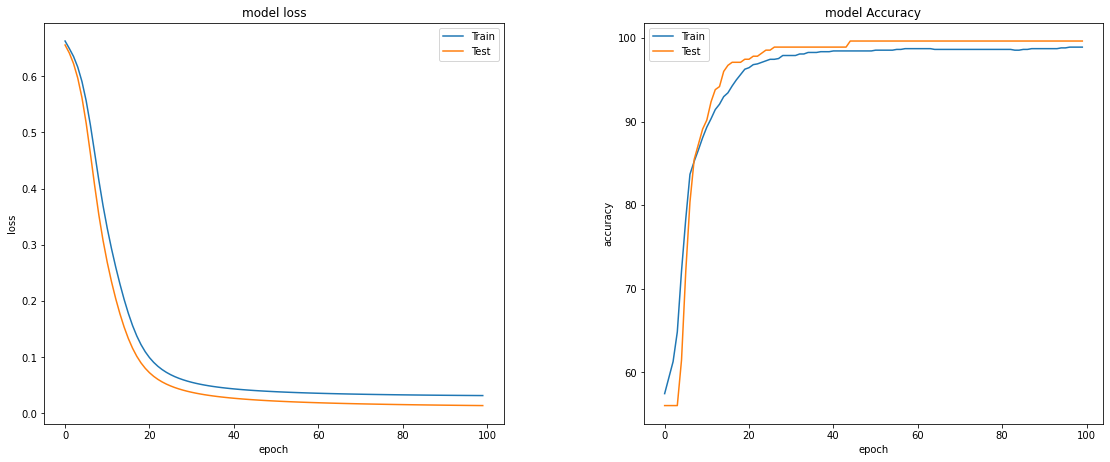

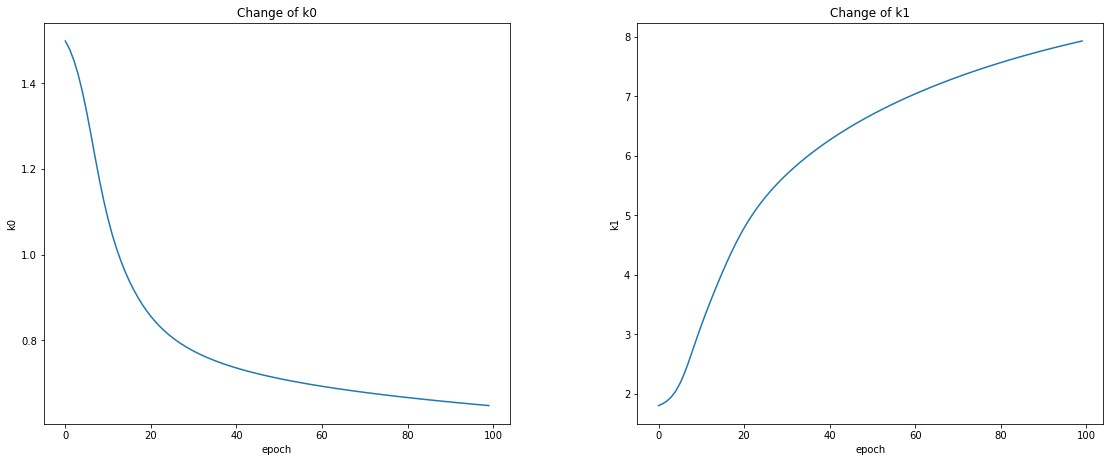

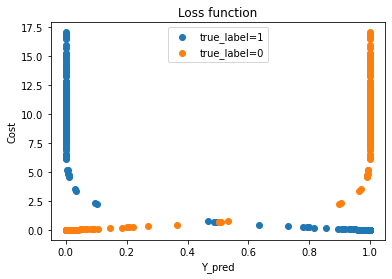

Train Accuracy:  98.81494986326345
Test Accuracy:  99.63636363636364
F1 Score on Test data :  0.995850622406639


In [69]:
# all the data processing utility functions are called 
dataset = load_csv()
for i in range(len(dataset[0])-1):
    str_column_to_float(dataset, i)
# convert class column to integers
str_column_to_int(dataset, len(dataset[0])-1)
minm = minmax(dataset)
normalize(dataset, minm)

l_rate = 0.001

n_epoch = 100 #number of epochs
n_hidden = 2 #number of hidden layers
seed(36)
'''
the run_algorithms then uses the processed dataset and call back_propagation which in turn calls 
all the training function and returns the train and test predictions of the best model.
These predictions are then used to calculate accuracy and F1 score.
'''

run_algorithm(dataset, back_propagation,  l_rate, n_epoch, n_hidden)
